In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly

In [164]:
FOLDER_PATH = 'dataset/'

def load_data(filename):
    return pd.read_csv(FOLDER_PATH + filename)

df_tt = load_data('Turbine_telemetry.csv')
df_rd = load_data('Residential_demand.csv')
df_wd = load_data('kirkwall_weather.csv')

print(f"turbine telemetry shape: {df_tt.shape}")
print(f"residential demand shape: {df_rd.shape}")
print(f"weather data shape: {df_wd.shape}")




turbine telemetry shape: (1069636, 4)
residential demand shape: (17568, 3)
weather data shape: (16584, 9)


# Cleaning Turbine Telemetry Data

## Removing Data Points Where Wind Speed Is Fast Enough But No Power

In [170]:
# Find the minimum wind speed for power production
v_min = df_tt[(df_tt.loc[:, 'Power_kw'] >= 10.)].loc[:, 'Wind_ms'].quantile(0.1) # 10% quantile minimum speed

# Select only rows with Setpoint_kw == 900
df_tt = df_tt.query('Setpoint_kw==900').copy()

# remove data points when the wind speed is fast enough for power production but there is no power; turbine is probably manually switched off here
df_tt.loc[((df_tt.Wind_ms >= v_min) & (df_tt.Power_kw.abs() <= 1e-5))] = np.nan

# remove all missing values from the dataframe
df_tt.dropna(inplace=True)

# Convert timestamp to datetime
df_tt['Timestamp'] = pd.to_datetime(df_tt['Timestamp'])

print(f"turbine telemetry data shape: {df_tt.shape}")

df_tt.head()

turbine telemetry data shape: (931488, 4)


,Timestamp,Power_kw,Setpoint_kw,Wind_ms
0,2015-05-28 00:00:23,80.0,900.0,4.9
1,2015-05-28 00:01:23,78.0,900.0,5.4
2,2015-05-28 00:02:23,52.0,900.0,4.9
3,2015-05-28 00:03:23,57.0,900.0,4.6
4,2015-05-28 00:04:23,54.0,900.0,4.6


In [ ]:
df_tt_timeindex = df_tt.copy()

# Set the timestamp as index 
df_tt_timeindex['Timestamp'] = pd.to_datetime(df_tt_timeindex['Timestamp'])

df_tt_timeindex = df_tt_timeindex.set_index('Timestamp')

# Resample the data to 30-minute intervals
df_tt_resampled = df_tt_timeindex.resample('30min').mean()

# Select the data for the year 2017
df_tt_resampled_2017 = df_tt_resampled[
    (df_tt_resampled.index >= '2017-01-01') &
    (df_tt_resampled.index < '2018-01-02')
]


dtype('<M8[ns]')

## Clean Resampled

In [ ]:
df_tt_resampled['Month'] = df_tt_resampled.index.to_period('M')
df_tt_resampled['Month_int'] = df_tt_resampled['Month'].dt.month
df_tt_resampled['Year_int'] = df_tt_resampled.index.to_period('Y').year

df_tt_resampled.head()

,Power_kw,Setpoint_kw,Wind_ms,Month,Month_int,Year_int
Timestamp,,,,,,
2015-05-28 00:00:00,103.0,900.0,5.533333,2015-05,5,2015
2015-05-28 00:30:00,204.0,900.0,7.040000,2015-05,5,2015
2015-05-28 01:00:00,285.6,900.0,7.876667,2015-05,5,2015
2015-05-28 01:30:00,457.4,900.0,9.166667,2015-05,5,2015
2015-05-28 02:00:00,891.9,900.0,12.973333,2015-05,5,2015


## Clean Original Timeseries

In [ ]:
df_tt['Month'] = df_tt['Timestamp'].dt.to_period('M')
df_tt['Month_int'] = df_tt['Month'].dt.month
df_tt['Year_int'] = df_tt['Timestamp'].dt.year

df_tt.head()

,Timestamp,Power_kw,Setpoint_kw,Wind_ms,Month,Month_int,Year_int
0,2015-05-28 00:00:23,80.0,900.0,4.9,2015-05,5,2015
1,2015-05-28 00:01:23,78.0,900.0,5.4,2015-05,5,2015
2,2015-05-28 00:02:23,52.0,900.0,4.9,2015-05,5,2015
3,2015-05-28 00:03:23,57.0,900.0,4.6,2015-05,5,2015
4,2015-05-28 00:04:23,54.0,900.0,4.6,2015-05,5,2015


# Scraped Weather Data Cleaning

In [ ]:

df_wd = load_data('kirkwall_weather.csv')
# Cleaning weather data
df_wd = df_wd.rename(columns={'Time': 'Timestamp'})
# Convert timestamp to datetime
df_wd['Timestamp'] = pd.to_datetime(df_wd['Timestamp'])

# Sort value based on timestamp
df_wd = df_wd.sort_values('Timestamp').reset_index(drop=True)

# aligning timestamp 00:20 into 00:30 and 00:50 to 01:00
df_wd['Timestamp'] = df_wd.Timestamp.apply(lambda x: x + pd.Timedelta(minutes=10))

df_wd['Wind Speed (m/s)'] = pd.to_numeric(df_wd['Wind Speed (m/s)'], errors='coerce').fillna(0.0)


print(f"Weather scrape columns: {df_wd.columns}")
df_wd.head()

Weather scrape columns: Index(['Timestamp', 'Icon', 'Temperature (F)', 'Description',
       'Wind Speed (m/s)', 'Wind Direction', 'Humidity (%)', 'Pressure (Hg)',
       'Visibility (mi)'],
      dtype='object')


,Timestamp,Icon,Temperature (F),Description,Wind Speed (m/s),Wind Direction,Humidity (%),Pressure (Hg),Visibility (mi)
0,2017-01-01 00:30:00,Passing clouds.,41,Passing clouds.,10.28,Wind blowing from 340° North-northwest to Sout...,81.0,30.04,NaN
1,2017-01-01 01:00:00,Quite cool.,43,Quite cool.,9.39,Wind blowing from 330° North-northwest to Sout...,81.0,30.04,NaN
2,2017-01-01 01:30:00,Passing clouds.,41,Passing clouds.,9.83,Wind blowing from 340° North-northwest to Sout...,87.0,30.04,NaN
3,2017-01-01 02:00:00,Passing clouds.,39,Passing clouds.,7.15,Wind blowing from 330° North-northwest to Sout...,87.0,30.07,5.0
4,2017-01-01 02:30:00,Passing clouds.,41,Passing clouds.,8.94,Wind blowing from 330° North-northwest to Sout...,76.0,30.07,NaN


## Join TT with Scraped Data

In [ ]:
df_tt_resampled_2017 = df_tt_resampled_2017.reset_index()

# inner join resample 2017 turbine telemetry data with weather data  
df_tt_wd = pd.merge(
    df_wd[['Timestamp', 'Wind Speed (m/s)']],
    df_tt_resampled_2017[['Timestamp', 'Wind_ms', 'Power_kw']],
    how='inner',
    on='Timestamp'
)

# Rename columns for clarity
df_tt_wd = df_tt_wd.rename(columns={
    'Wind Speed (m/s)': 'Wind_speed_scraped',
    'Wind_ms': 'Wind_speed_baseline',
    'Power_kw': 'Power_baseline'
})

# Ensure Timestamp is a datetime
df_tt_wd['Timestamp'] = pd.to_datetime(df_tt_wd['Timestamp'])

# Create a 'Month' column for grouping
df_tt_wd['Month'] = df_tt_wd['Timestamp'].dt.to_period('M')


# Show result
df_tt_wd.head()


,Timestamp,Wind_speed_scraped,Wind_speed_baseline,Power_baseline,Month
0,2017-01-01 00:30:00,10.28,16.106667,898.266667,2017-01
1,2017-01-01 01:00:00,9.39,16.380000,902.866667,2017-01
2,2017-01-01 01:30:00,9.83,17.083333,907.833333,2017-01
3,2017-01-01 02:00:00,7.15,16.800000,907.000000,2017-01
4,2017-01-01 02:30:00,8.94,18.021739,906.152174,2017-01


# Scrape and Baseline Analysis

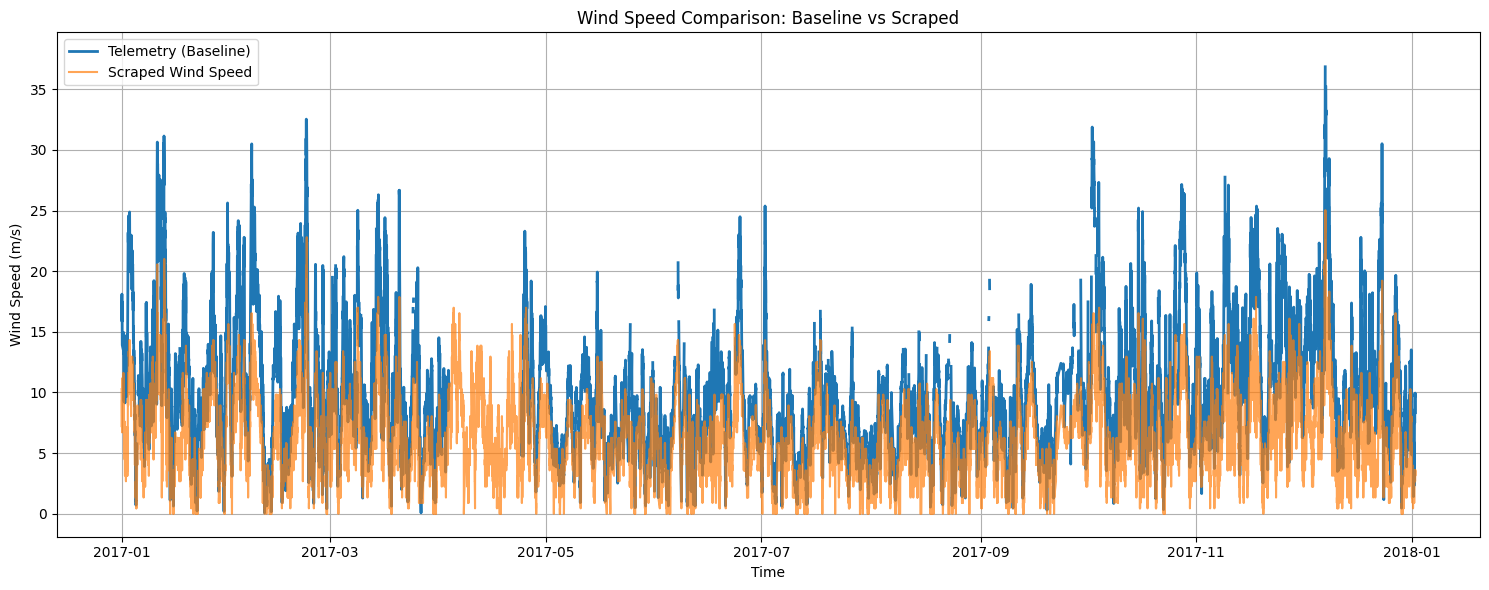

In [66]:
# Plot over time
plt.figure(figsize=(15, 6))

plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_baseline'], label='Telemetry (Baseline)', linewidth=2)
plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_scraped'], label='Scraped Wind Speed', alpha=0.7)
# plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_monthly_scaled'], label='Corrected Wind Speed', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Comparison: Baseline vs Scraped')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Correlation Scraped-Baseline

In [179]:
# Calculation Correlation Between Wind Speed and Wind Speed Baseline
correlation = df_tt_wd['Wind_speed_scraped'].corr(df_tt_wd['Wind_speed_baseline'])
print("Correlation:", correlation)


Correlation: 0.8423792547394562


## Scaling with Monthly Percentage Differences

In [64]:
# Calculate monthly means
monthly_means = df_tt_wd.groupby('Month')[['Wind_speed_scraped', 'Wind_speed_baseline']].mean()

# Calculate correction factors
monthly_means['correction_factor'] = monthly_means['Wind_speed_baseline'] / monthly_means['Wind_speed_scraped']

# Join the correction factor back to the main dataframe
df_tt_wd = df_tt_wd.merge(monthly_means['correction_factor'], on='Month', how='left')

# Apply the correction
df_tt_wd['Wind_speed_monthly_scaled'] = df_tt_wd['Wind_speed_scraped'] * df_tt_wd['correction_factor']

monthly_means.head()


,Wind_speed_scraped,Wind_speed_baseline,correction_factor
Month,,,
2017-01,7.024976,11.909933,1.695370
2017-02,6.836293,11.803518,1.726596
2017-03,6.335610,10.563270,1.667285
2017-04,7.347837,10.880955,1.480838
2017-05,5.313900,7.740323,1.456618


In [180]:
# New Dataframe with the correction factor and scaled wind speed

df_tt_wd.head()

,Timestamp,Wind_speed_scraped,Wind_speed_baseline,Power_baseline,Month
0,2017-01-01 00:30:00,10.28,16.106667,898.266667,2017-01
1,2017-01-01 01:00:00,9.39,16.380000,902.866667,2017-01
2,2017-01-01 01:30:00,9.83,17.083333,907.833333,2017-01
3,2017-01-01 02:00:00,7.15,16.800000,907.000000,2017-01
4,2017-01-01 02:30:00,8.94,18.021739,906.152174,2017-01


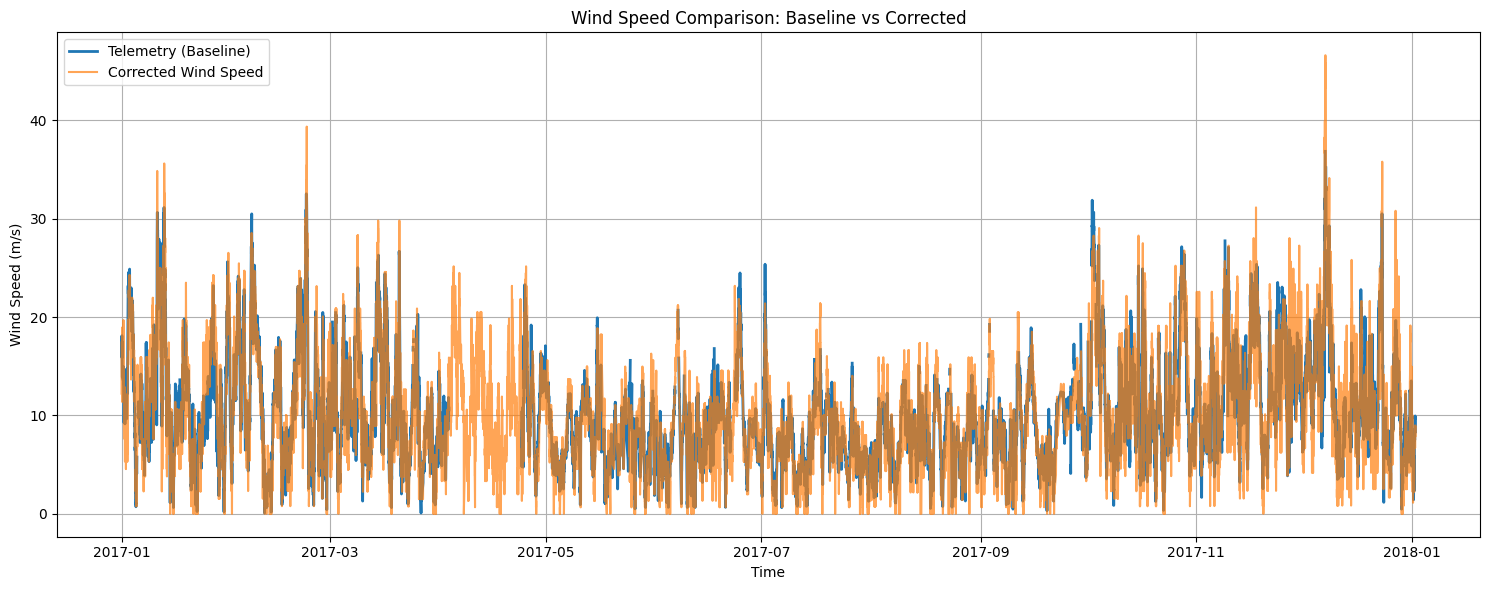

In [97]:
# Plot over time
plt.figure(figsize=(15, 6))

plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_baseline'], label='Telemetry (Baseline)', linewidth=2)
# plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_scraped'], label='Scraped Wind Speed', alpha=0.7)
plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_monthly_scaled'], label='Corrected Wind Speed', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Comparison: Baseline vs Corrected')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scale with Z-Scale

In [68]:
# I dont think its correct to scale with z-scale since it is not a normal distribution

# Energy Generated

$$
P = \frac{1}{2} \cdot \rho \cdot A \cdot v^3 \cdot C_p
$$

Where:

* $P$ = power output (in watts, W)
* $\rho$ = air density (in kg/m³), typically \~1.225 kg/m³ at sea level
* $A$ = swept area of the rotor (in m²), $A = \pi r^2$
* $v$ = wind speed (in m/s)
* $C_p$ = power coefficient (efficiency), typically $\leq 0.59$ due to **Betz's limit**

In [69]:
df_tt_wd.head()

,Timestamp,Wind_speed_scraped,Wind_speed_baseline,Power_baseline,Month,correction_factor,Wind_speed_monthly_scaled
0,2017-01-01 00:30:00,10.28,16.106667,898.266667,2017-01,1.69537,17.428404
1,2017-01-01 01:00:00,9.39,16.380000,902.866667,2017-01,1.69537,15.919524
2,2017-01-01 01:30:00,9.83,17.083333,907.833333,2017-01,1.69537,16.665487
3,2017-01-01 02:00:00,7.15,16.800000,907.000000,2017-01,1.69537,12.121896
4,2017-01-01 02:30:00,8.94,18.021739,906.152174,2017-01,1.69537,15.156608


In [70]:
df_tt_wd[df_tt_wd.Month == '2017-02'].head(10)

,Timestamp,Wind_speed_scraped,Wind_speed_baseline,Power_baseline,Month,correction_factor,Wind_speed_monthly_scaled
1447,2017-02-01 00:00:00,4.02,5.027586,53.965517,2017-02,1.726596,6.940917
1448,2017-02-01 00:30:00,4.02,4.566667,39.600000,2017-02,1.726596,6.940917
1449,2017-02-01 01:00:00,3.13,4.551724,39.068966,2017-02,1.726596,5.404246
1450,2017-02-01 02:00:00,1.34,4.424138,35.758621,2017-02,1.726596,2.313639
1451,2017-02-01 02:30:00,4.02,4.937931,48.689655,2017-02,1.726596,6.940917
1452,2017-02-01 03:00:00,4.02,4.890000,58.133333,2017-02,1.726596,6.940917
1453,2017-02-01 03:30:00,4.02,4.673333,43.433333,2017-02,1.726596,6.940917
1454,2017-02-01 04:00:00,4.02,4.903448,51.241379,2017-02,1.726596,6.940917
1455,2017-02-01 04:30:00,3.58,5.123333,58.300000,2017-02,1.726596,6.181214
1456,2017-02-01 05:00:00,0.45,5.003333,52.533333,2017-02,1.726596,0.776968


In [71]:
(0.5 * 1.225 * (np.pi * (25**2)) * (5.013333 ** 3) * 0.35)/1000

53.037578235989486

### Deriving Rotor Radius

In [72]:
# Constants
rho = 1.225  # air density in kg/m³
cp = 0.35    # power coefficient
pi = np.pi

# Only use data where baseline power is below setpoint
valid = (df_tt_wd['Power_baseline'] < 880) & (df_tt_wd['Power_baseline'] > 20)

# Use the corrected wind speed and power baseline
P = df_tt_wd.loc[valid, 'Power_baseline'] * 1000  # convert kW to W
v = df_tt_wd.loc[valid, 'Wind_speed_baseline']

# Avoid division by zero or very small wind speeds
safe = v > 0
P = P[safe]
v = v[safe]

# Calculate rotor radius and diameter
r = np.sqrt((2 * P) / (rho * pi * v**3 * cp))

print(f"Mean rotor radius: {r.mean()} m")
print(f"Standard deviation of rotor radius: {r.std()} m")
print(f"Min rotor radius: {r.min()} m")
print(f"Max rotor radius: {r.max()} m")





Mean rotor radius: 25.914737933905894 m
Standard deviation of rotor radius: 3.6353248331742614 m
Min rotor radius: 1.0085586470582693 m
Max rotor radius: 40.838466626491815 m


## Naive Approach - calculate estimated power using scraped wind data

In [73]:
_r = r.mean()

df_tt_wd['Naive_Power_scraped'] = (0.5 * rho * (np.pi * (_r**2)) * (df_tt_wd['Wind_speed_monthly_scaled'] ** 3) * cp) / 1000
#add cap to 900
df_tt_wd['Naive_Power_scraped'] = df_tt_wd['Naive_Power_scraped'].clip(upper=900)

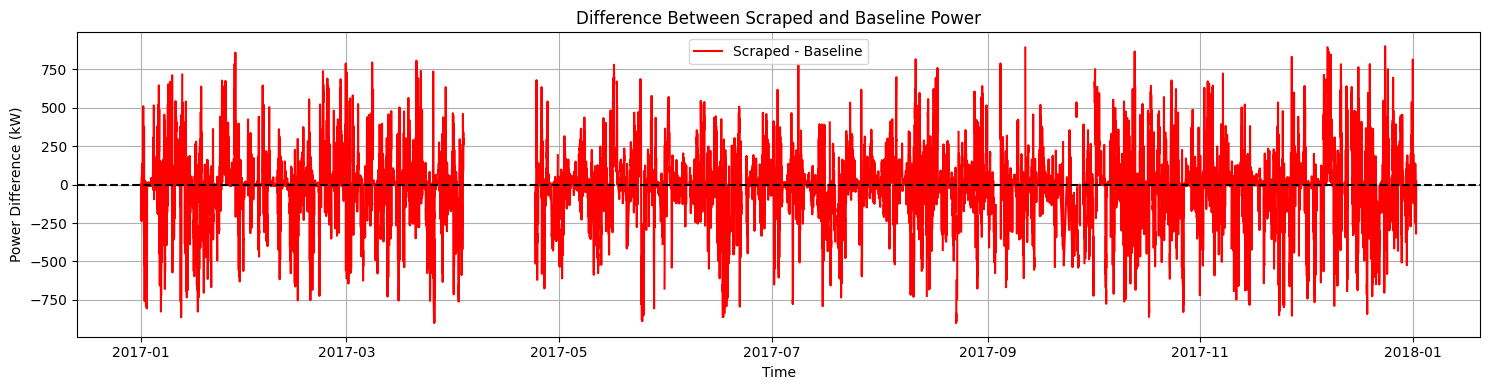

In [74]:
df_tt_wd['Naive_Power_diff'] = df_tt_wd['Naive_Power_scraped'] - df_tt_wd['Power_baseline']

plt.figure(figsize=(15, 4))
plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Naive_Power_diff'], color='red', label='Scraped - Baseline')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Power Difference (kW)')
plt.title('Difference Between Scraped and Baseline Power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Check Correlation of Power Estimated and Baseline

In [75]:
df_tt_wd[['Naive_Power_scraped', 'Power_baseline']].corr()


,Naive_Power_scraped,Power_baseline
Naive_Power_scraped,1.000000,0.795584
Power_baseline,0.795584,1.000000


In [152]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Only compare where both values are available (i.e., not NaN)
valid_mse = df_tt_wd[['Naive_Power_scraped', 'Power_baseline']].dropna()

mse_naive = mean_squared_error(valid_mse['Power_baseline'], valid_mse['Naive_Power_scraped'])
rmse_naive = np.sqrt(mse_naive)
r2_naive = r2_score(valid_mse['Power_baseline'], valid_mse['Naive_Power_scraped'])

print(f"Naive MSE: {mse_naive:.2f} kW²")
print(f"Naive RMSE: {rmse_naive:.2f} kW")
print(f"Naive R² Score: {r2_naive:.4f}")

Naive MSE: 49701.56 kW²
Naive RMSE: 222.94 kW
Naive R² Score: 0.5606


# Simple Linear Model

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Drop rows where either X or y is NaN
df_clean = df_tt_wd[['Wind_speed_baseline', 'Power_baseline']].dropna()

X = df_clean[['Wind_speed_baseline']]
y = df_clean['Power_baseline']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Linear Regression R² Score: {r2:.3f}")


Mean Squared Error: 26814.75
Linear Regression R² Score: 0.764


In [77]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(3), LinearRegression())
model.fit(X_train, y_train)
y_pred_poly = model.predict(X_test)
print(f"Polynomial Regression R²: {r2_score(y_test, y_pred_poly):.3f}")


Polynomial Regression R²: 0.934


# Random Forest 

In [163]:
from sklearn.ensemble import RandomForestRegressor

X = df_clean[['Wind_speed_baseline']]
y = df_clean['Power_baseline']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f"Random Forest R²: {r2_score(y_test, y_pred_rf):.3f}")


Random Forest R²: 0.992


In [161]:
df_tt_wd

,Timestamp,Wind_speed_scraped,Wind_speed_baseline,Power_baseline,Month,correction_factor,Wind_speed_monthly_scaled,Naive_Power_scraped,Naive_Power_diff,Month_int,XGBoost_Power_scraped,XGBoost_Power_diff,Random_Forest_Power_scraped,Random_Forest_Power_diff
0,2017-01-01 00:30:00,10.28,16.106667,898.266667,2017-01,1.695370,17.428404,900.000000,1.733333,1,898.683777,0.417110,551.016075,-347.250592
1,2017-01-01 01:00:00,9.39,16.380000,902.866667,2017-01,1.695370,15.919524,900.000000,-2.866667,1,898.819580,-4.047087,437.954146,-464.912521
2,2017-01-01 01:30:00,9.83,17.083333,907.833333,2017-01,1.695370,16.665487,900.000000,-7.833333,1,900.264160,-7.569173,496.066836,-411.766497
3,2017-01-01 02:00:00,7.15,16.800000,907.000000,2017-01,1.695370,12.121896,805.618204,-101.381796,1,845.867737,-61.132263,187.180177,-719.819823
4,2017-01-01 02:30:00,8.94,18.021739,906.152174,2017-01,1.695370,15.156608,900.000000,-6.152174,1,896.829834,-9.322340,367.641987,-538.510187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16578,2018-01-01 21:30:00,3.58,9.700000,439.766667,2018-01,2.499539,8.948351,324.075882,-115.690784,1,358.822418,-80.944248,9.525625,-430.241042
16579,2018-01-01 22:00:00,2.68,9.670000,455.466667,2018-01,2.499539,6.698766,135.957138,-319.509529,1,146.296463,-309.170204,0.942324,-454.524342
16580,2018-01-01 22:30:00,3.58,9.950000,470.633333,2018-01,2.499539,8.948351,324.075882,-146.557451,1,358.822418,-111.810915,9.525625,-461.107708
16581,2018-01-01 23:00:00,3.13,9.213333,408.466667,2018-01,2.499539,7.823558,216.586132,-191.880535,1,237.449875,-171.016792,4.021270,-404.445397


In [ ]:

X_scraped = df_tt_wd[['Wind_speed_scraped']]
X_scraped = X_scraped.rename(columns={'Wind_speed_scraped': 'Wind_speed_baseline'})

y_pred_rf_scrape = rf.predict(X_scraped)
df_tt_wd['Random_Forest_Power_scraped'] = y_pred_rf_scrape
df_tt_wd['Random_Forest_Power_diff'] = df_tt_wd['Random_Forest_Power_scraped'] - df_tt_wd['Power_baseline']

valid_rf = df_tt_wd[['Random_Forest_Power_scraped', 'Power_baseline']].dropna()
mse_rf = mean_squared_error(valid_rf['Power_baseline'], valid_rf['Random_Forest_Power_scraped'])
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(valid_rf['Power_baseline'], valid_rf['Random_Forest_Power_scraped'])

print(f"Random Forest MSE: {mse_rf:.2f} kW²")
print(f"Random Forest RMSE: {rmse_rf:.2f} kW")
print(f"Random Forest R² Score: {r2_rf:.4f}")



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- hour
- lag1_power
- rolling_mean_3
- wind_sq


# Random Forest Add Month

In [90]:
df_tt_wd['Month_int'] = df_tt_wd['Timestamp'].dt.month

X = df_tt_wd[['Wind_speed_baseline', 'Month_int']].dropna()
y = df_tt_wd.loc[X.index, 'Power_baseline']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(f"Random Forest R² with Month: {r2_score(y_test, y_pred_rf):.3f}")

Random Forest R² with Month: 0.993


## XgBoost

In [148]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Prepare features
X = df_tt[['Wind_ms','Month_int']].dropna()
y = df_tt.loc[X.index, 'Power_kw']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred_xgb)
mse = mean_squared_error(y_test, y_pred_xgb)

print(f"XGBoost R²: {r2:.3f}")
print(f"XGBoost MSE: {mse:.2f}")


XGBoost R²: 0.978
XGBoost MSE: 2537.78


In [149]:
X_scraped = df_tt_wd[['Wind_speed_monthly_scaled', "Month_int"]]
X_scraped = X_scraped.rename(columns={'Wind_speed_monthly_scaled': 'Wind_ms'})

y_pred_scraped = xgb_model.predict(X_scraped)

df_tt_wd['XGBoost_Power_scraped'] = y_pred_scraped
df_tt_wd['XGBoost_Power_diff'] = df_tt_wd['XGBoost_Power_scraped'] - df_tt_wd['Power_baseline']

In [150]:
# Ensure no NaNs interfere
valid_xgb = df_tt_wd[['XGBoost_Power_scraped', 'Power_baseline']].dropna()

mse_xgb = mean_squared_error(valid_xgb['Power_baseline'], valid_xgb['XGBoost_Power_scraped'])
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(valid_xgb['Power_baseline'], valid_xgb['XGBoost_Power_scraped'])

print(f"XGBoost MSE: {mse_xgb:.2f} kW²")
print(f"XGBoost RMSE: {rmse_xgb:.2f} kW")
print(f"XGBoost R² Score: {r2_xgb:.4f}")

XGBoost MSE: 48887.74 kW²
XGBoost RMSE: 221.11 kW
XGBoost R² Score: 0.5678


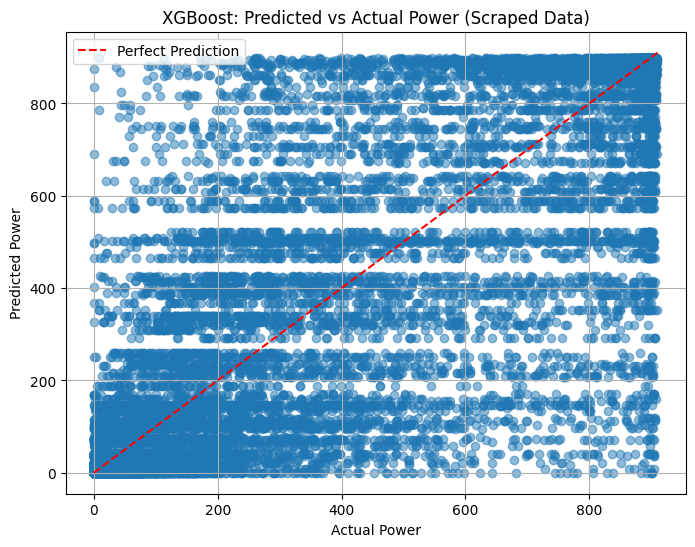

In [ ]:


y_actual = df_tt_wd['Power_baseline']



plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred_scraped, alpha=0.5)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Power")
plt.ylabel("Predicted Power")
plt.title("XGBoost: Predicted vs Actual Power (Scraped Data)")
plt.legend()
plt.grid(True)
plt.show()

